**Importing necessary libraries and dataset**

In [1]:
! pip install pyLDAvis

In [2]:
import numpy as np
import pandas as pd
import nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# pickle to save model
import pickle

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [3]:
# Import Dataset
df = pd.read_csv('/content/User_Reviews.csv')
df.head()

,Text
0,I absolutly love this modle. It is soooooooo c...
1,I love this parfum spray. I was very pleased a...
2,"We love this collar! It's sturdy, convenient, ..."
3,The game that made me the most competitive foo...
4,Got this for my boyfriend after smelling it in...


In [4]:
len(df)

3227

**Preprocessing data**

1. Tokenize and Clean-up using gensim’s simple_preprocess()

In [5]:
# Convert to list
data = df['Text'].values.tolist()

def sent_to_words(sentences):
    """Tokenizing the sentences to words"""
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations and accent marks from letters

data_words = list(sent_to_words(data))

print(data_words[:1])

[['absolutly', 'love', 'this', 'modle', 'it', 'is', 'soooooooo', 'cool', 'am', 'big', 'smarty', 'jones', 'fan', 'so', 'this', 'was', 'must', 'have', 'it', 'is', 'not', 'really', 'made', 'for', 'playing', 'with', 'more', 'like', 'on', 'display', 'shelf', 'half', 'special', 'section', 'for', 'him']]


2. Lemmatization
  - Lemmatization is a process where we convert words to its root word.

  - For example: ‘Studying’ becomes ‘Study’, ‘Meeting becomes ‘Meet’, ‘Better’ and ‘Best’ becomes ‘Good’.

In [6]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation
       Extracting root words   
    """
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [7]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['absolutly love modle soooooooo cool fan must really make play more like display shelf half special section', 'love parfum spray very pleased price as well size bottle will last very long time old cologne difficult find store impossible yet find problem com so reliable will definitely order again again']


3. Create the Document-Word matrix

In [8]:
vectorizer = CountVectorizer(
                             min_df=2,                         # minimum reqd occurences of a word
                             max_df=0.9,                       # ignore terms that have a document frequency strictly higher than max_df
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             ngram_range=(1,3)                 # considering unigrams, bigrams and trigrams
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

4. Check the Sparsicity

In [9]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.2335220305836238 %


**Model selection and model building**

In [10]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=10,           # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', n_jobs=-1, random_state=100)


In [11]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -1141345.5246782233
Perplexity:  4244.70513828538
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


Topic model visualization

In [12]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
panel

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distan

PreparedData(topic_coordinates=               x          y  topics  cluster       Freq
topic                                                  
9      32.420952   8.115230       1        1  50.524210
2       0.648955  71.707100       2        1  22.170345
6      71.019684   9.971006       3        1  14.596731
3       3.785981  33.185135       4        1   3.478974
4     -42.666500  -9.222070       5        1   2.377776
0      -3.621689 -43.526516       6        1   2.232346
8      -3.632402  -4.171708       7        1   1.874426
7     -36.584400  35.804413       8        1   1.032629
5      44.391380  50.615383       9        1   0.920263
1      40.235809 -31.591665      10        1   0.792299, topic_info=               Term        Freq       Total Category  logprob  loglift
4902           game  689.000000  689.000000  Default  30.0000  30.0000
13670           toy  904.000000  904.000000  Default  29.0000  29.0000
9586           play  779.000000  779.000000  Default  28.0000  28.0000
5570           hair  920.000000  920.000000  Default  27.0000  27.0000
1626            cat  621.000000  621.000000  Default  26.0000  26.0000
...             ...         ...         ...      ...      ...      ...
8297    miss rubber    1.409891    2.079703  Topic10  -6.6435   4.4493
2668          creep    1.400691    2.070573  Topic10  -6.6501   4.4471
10259  professional    2.089619   12.990057  Topic10  -6.2501   3.0108
8295           miss    1.782384   29.066384  Topic10  -6.4091   2.0464
1579        careful    1.767030   41.512711  Topic10  -6.4178   1.6813

[538 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
137        1  0.514882     addition
137        2  0.220664     addition
137        6  0.245182     addition
146        9  0.947314     adhesive
187        1  0.996112          age
...      ...       ...          ...
15326      1  0.995917     year old
15393      8  0.656547   year worth
15406      1  0.989707        young
15418     10  0.474535  young woman
15433      6  0.862418         zoid

[762 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 3, 7, 4, 5, 1, 9, 8, 6, 2])

*From the above visualization, the topics are well separated. Now we have to optimize the number of topics present and classify the reviews based on the optimum number of topics.*

- To find out the optimum number of topics, Kmeans clustering and PCA is used here to plot the elbow curve and obtain the k value(It is the value after which there is a linear change in the curve with minimal deflection)

In [13]:
cv_norm = normalize(data_vectorized)
cv_array = cv_norm.toarray()

In [14]:
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(cv_array)
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

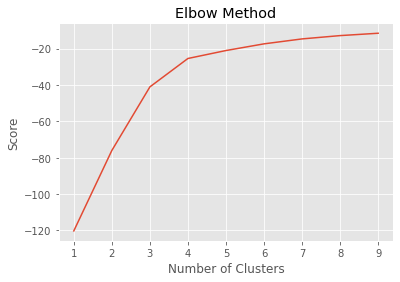

In [15]:
number_clusters = range(1, 10)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
kmeans

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score

plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

*Based on above elbow method, the optimum number of topics = 4. Hence, update the LDA model with n_components=4.*

In [16]:
# Build LDA Model
lda_model_final = LatentDirichletAllocation(n_components=4,      # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model_final.fit_transform(data_vectorized)

print(lda_model_final)  # Model attributes

LatentDirichletAllocation(learning_method='online', n_components=4, n_jobs=-1,
                          random_state=100)


In [17]:
pyLDAvis.enable_notebook()
panel_final = pyLDAvis.sklearn.prepare(lda_model_final, data_vectorized, vectorizer, mds='tsne')
panel_final

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:827: FutureWarning: 'square_distan

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2      269.562408 -124.803398       1        1  45.145165
0        1.782994 -295.079681       2        1  35.350312
3      220.811432 -343.832123       3        1  10.606227
1       50.533993  -76.050934       4        1   8.898296, topic_info=          Term         Freq        Total Category  logprob  loglift
13670      toy   900.000000   900.000000  Default  30.0000  30.0000
14207      use  1433.000000  1433.000000  Default  29.0000  29.0000
4902      game   809.000000   809.000000  Default  28.0000  28.0000
9586      play   790.000000   790.000000  Default  27.0000  27.0000
10068  product  1039.000000  1039.000000  Default  26.0000  26.0000
...        ...          ...          ...      ...      ...      ...
2866       day    40.563224   432.942560   Topic4  -5.7029   0.0516
7493      look    37.928495   490.136424   Topic4  -5.7700  -0.1397
12127    smell    35.643245   326.853616   Topic4  -5.8322   0.2034
5358     great    37.171199   863.364169   Topic4  -5.7902  -0.7260
7668      love    34.823951  1116.523258   Topic4  -5.8554  -1.0484

[294 rows x 6 columns], token_table=       Topic      Freq      Term
term                            
69         4  0.988008      acne
160        2  0.993896     adult
187        1  0.035354       age
187        2  0.848504       age
187        3  0.026516       age
...      ...       ...       ...
15289      3  0.081252      year
15289      4  0.043528      year
15326      1  0.053961  year old
15326      2  0.937565  year old
15326      3  0.006745  year old

[437 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 2])

**Mapping the topics against the reviews**

In [18]:
topic_results = lda_model_final.transform(data_vectorized)

In [19]:
df['Topic'] = topic_results.argmax(axis=1)

In [20]:
df.head()

,Text,Topic
0,I absolutly love this modle. It is soooooooo c...,0
1,I love this parfum spray. I was very pleased a...,3
2,"We love this collar! It's sturdy, convenient, ...",2
3,The game that made me the most competitive foo...,0
4,Got this for my boyfriend after smelling it in...,3


In [21]:
# Checking the top 15 words of each topic to compare and map the results according to the above visualization
for index,topic in enumerate(lda_model_final.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['good', 'year old', 'son', 'time', 'just', 'make', 'fun', 'buy', 'year', 'great', 'old', 'love', 'play', 'game', 'toy']


THE TOP 15 WORDS FOR TOPIC #1


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['cream', 'wash', 'conditioner', 'lotion', 'flea', 'face', 'feel', 'brush', 'work', 'dry', 'hair', 'shampoo', 'product', 'use', 'skin']


THE TOP 15 WORDS FOR TOPIC #2
['box', 'good', 'try', 'love', 'great', 'time', 'buy', 'make', 'just', 'work', 'cat', 'product', 'hair', 'dog', 'use']


THE TOP 15 WORDS FOR TOPIC #3
['order', 'price', 'time', 'cologne', 'great', 'buy', 'wear', 'bottle', 'fragrance', 'perfume', 'love', 'product', 'good', 'scent', 'smell']




In [22]:
# Numbering the model topics based on the visualization
visual_topics = {0:2, 1:4, 2:1, 3:3}

In [23]:
df['visual_topics'] = df['Topic'].map(visual_topics)

In [24]:
df.head()

,Text,Topic,visual_topics
0,I absolutly love this modle. It is soooooooo c...,0,2
1,I love this parfum spray. I was very pleased a...,3,3
2,"We love this collar! It's sturdy, convenient, ...",2,1
3,The game that made me the most competitive foo...,0,2
4,Got this for my boyfriend after smelling it in...,3,3


In [25]:
# Labeling the topics based on the top words
topic_names = {1:'Pet_care', 2:'Kids_games', 3:'Perfumes', 4:'Hair_products'}

In [26]:
df['topic_names'] = df['visual_topics'].map(topic_names)

In [27]:
df.head()

,Text,Topic,visual_topics,topic_names
0,I absolutly love this modle. It is soooooooo c...,0,2,Kids_games
1,I love this parfum spray. I was very pleased a...,3,3,Perfumes
2,"We love this collar! It's sturdy, convenient, ...",2,1,Pet_care
3,The game that made me the most competitive foo...,0,2,Kids_games
4,Got this for my boyfriend after smelling it in...,3,3,Perfumes


In [28]:
df_submission = df[['Text','topic_names']]

In [29]:
df_submission.head()

,Text,topic_names
0,I absolutly love this modle. It is soooooooo c...,Kids_games
1,I love this parfum spray. I was very pleased a...,Perfumes
2,"We love this collar! It's sturdy, convenient, ...",Pet_care
3,The game that made me the most competitive foo...,Kids_games
4,Got this for my boyfriend after smelling it in...,Perfumes


In [30]:
df_submission.to_csv('submission.csv')

**Saving the model and vectorizer**

In [31]:
from sklearn.pipeline import Pipeline
model = Pipeline([('cv', vectorizer),
                  ('clf', lda_model_final),
])

In [32]:
filename = 'topic_model.pkl'
pickle.dump(model, open(filename, 'wb'))

In [33]:
loaded_model = pickle.load(open(filename, 'rb'))

In [34]:
res = loaded_model.transform(df['Text'])

In [35]:
df1 = df.copy()

In [36]:
df1['results'] = res.argmax(axis=1)

In [37]:
df1

,Text,Topic,visual_topics,topic_names,results
0,I absolutly love this modle. It is soooooooo c...,0,2,Kids_games,0
1,I love this parfum spray. I was very pleased a...,3,3,Perfumes,3
2,"We love this collar! It's sturdy, convenient, ...",2,1,Pet_care,2
3,The game that made me the most competitive foo...,0,2,Kids_games,0
4,Got this for my boyfriend after smelling it in...,3,3,Perfumes,3
...,...,...,...,...,...
3222,My dog loves the squirrel but the squeaker bro...,2,1,Pet_care,2
3223,I have been using Adams Plus Flea & Tick mist ...,2,1,Pet_care,1
3224,"Great product, and sprinkling it on top of her...",2,1,Pet_care,2
3225,I really like this pen because it looks much b...,2,1,Pet_care,2


In [38]:
df1.to_csv('evaluate.csv')

In [39]:
pyLDAvis.save_html(panel, 'lda_10topics.html')
pyLDAvis.save_html(panel_final, 'lda_4topics.html')